In [1]:
#Ejemplo finiteautomata/bertweet-base-sentiment-analysis

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")

model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-sentiment-analysis")


#utulizando el modelo para predecir
text = "No me gusta la programación en Python"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
softmax(logits.detach().numpy())

#imprime la posición de la probabilidad más alta
print(np.argmax(softmax(logits.detach().numpy())))


C:\Users\izangale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\izangale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\izangale\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#lim

0


In [2]:
import pandas as pd

def load_data_tripadvisor(path:str):
    '''
    Funcion que procesa la base de datos a partir de la ruta en que se encuentra
    '''  
    df = pd.read_csv(path, sep='\t', index_col=0, names=['text', 'score'])
    df['Opinion'] = df['text'].str.split('_PROS_Liked_—_').str.get(0)
    df['PROS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(0).str.replace('_', ' ')
    df['CONS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(1).str.replace('_', ' ')
    df['Sentiment'] = df.apply(lambda row: get_score_tripadvisor(row),axis=1)
    return df
    
    
def get_score_tripadvisor(row):
    '''
    Funcion para reducir el abanico de puntuaciones a predecir.
    0: Negativa
    1: Neutral
    
    2: Positiva
    '''
    score = int(row['score'])
    if score < 3:
        return 0
    elif score < 4:
        return 1
    else:
        return 2

In [5]:
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
path = '/Users/izangale/Desktop/master/repo/master-ua/Minería de textos/TextClassification-main/01-SA-Pipeline/sample_data/ejercicio_tripadvisor.csv'

# descomente la siguiente línea para leer datos desde un URL
#path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/01-SA-Pipeline/sample_data/ejemplo_review_train.csv'

#importar el archivo .py de la siguiente ruta C:\Users\usuario\entorno\master-ua\Minería de textos\TextClassification-main\00-Utils\tripadvisor.py

#carga los datos con la función load_data del archivo tripadvisor.py
df = load_data_tripadvisor(path)

# mostrar los primeros registros
data = df
data.head()



,text,score,Opinion,PROS,CONS,Sentiment
274573_7795529,Good for the money Having read the reviews -...,4,Good for the money Having read the reviews -...,Location and Price,Beds,2
274573_6611183,Central location and good price Hotel Suisse...,3,Central location and good price Hotel Suisse...,NaN,NaN,1
274573_5823077,A great hotel in the middle of everything I...,3,A great hotel in the middle of everything I...,Location,Having to be buzzed in,1
274573_5326023,Great location but expensive and some restric...,3,Great location but expensive and some restric...,NaN,NaN,1
274573_5211722,Great comfort and value Comfortable and clea...,4,Great comfort and value Comfortable and clea...,NaN,NaN,2


In [6]:
text_col = 'Opinion'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

#cambia los datos de la class_col y asigna el valor negativa en caso de que sea 0, neutral en caso de que sea 1 y positiva en caso de que sea 2
#data[class_col] = data[class_col].apply(lambda x: 'negativa' if x == 0 else ('neutral' if x == 1 else 'positiva'))

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')


Total de instancias -> 10508
Distribución de clases:
    0: 0.113
    1: 0.1
    2: 0.787
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Good for the money  Having read the reviews - well it is Rome and you get what you pay for  Nice place and good location - remember that it is at the TOP of the Spanish steps - so if you prefer not to make the walk at the end of the day - pay more and stay at another hotel at the BOTTOM of the steps The staff were great and the bathroom was nice  The room was fine for what we paid Not recommended if you are looking for a  romantic  getaway  but for my sister and I - it was fine for all the tourist things we did  
Categoría del comentario -> 2


Done!


In [7]:
#iguala el numero de instancias a la clase que menos instancias tiene
data = data.groupby(class_col).apply(lambda x: x.sample(data[class_col].value_counts().min(), random_state=42)).reset_index(drop=True)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()


Total de instancias -> 3156
Distribución de clases:
    0: 0.333
    1: 0.333
    2: 0.333
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Mixed Review for the Exedra  Just like my rating says  this hotel is okay  but has some problems   Like the other reviewers  I felt the Exedra had a great location and was quite beautiful  The lobby looked like it had just been decorated  with beautiful new cream colored couches and furnishings  But please be prepared for the GIANT tacky headboard in your room - crocodile embossed leather  a bit much for my taste  The rooms were very nice  extremely spacious for Italy and not too pricey for a 5 star hotel - EUR 230 including breakfast  The breakfast was good and offered a sophisticated spread  smoked swordfish which was pretty good   I had previously stayed at the St Regis down the street  which is more expensive but has smaller rooms - however  the St Regis is more elegant  less modern than the Exedra  During my stay at the Exedra  the internet c

In [8]:
#creamos una lista de predicciones
from scipy.special import softmax
import numpy as np

predicciones = []
for i in range(len(data)): 
    text = data[text_col][i]
    if len(text) > 300:
        text = text[:300]
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    pos = softmax(logits.detach().numpy())
    predicciones.append(np.argmax(pos))



(3156,)
(3156,)
              precision    recall  f1-score   support

           0       0.74      0.62      0.67      1052
           1       0.46      0.20      0.28      1052
           2       0.54      0.93      0.68      1052

    accuracy                           0.58      3156
   macro avg       0.58      0.58      0.54      3156
weighted avg       0.58      0.58      0.54      3156



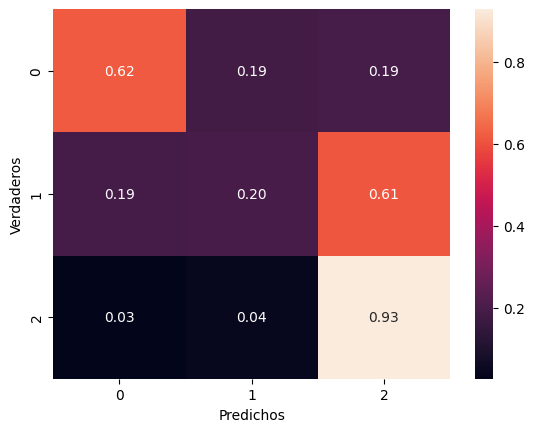

In [9]:
#ahora vamos a evaluar al modelo
#!pip install seaborn
from sklearn.metrics import classification_report
#antes de hacer el classification report, vammos a cambiar el tipo de la columna class_col a int
data[class_col] = data[class_col].astype(int)
predicciones = np.array(predicciones)
print(predicciones.shape)
print(data[class_col].shape)

print(classification_report(data[class_col], predicciones))


#ahora vamos a hacer una matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(data[class_col], predicciones)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=categories, yticklabels=categories)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

print('El ACCURACY es: ', accuracy_score(data[class_col], predicciones))

El ACCURACY es:  0.5804816223067174
